In [1]:
# import required libraries
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import yaml
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Calling the yaml file
with open("C:/Users/nitin/Desktop/Yaml/datapull.yml", 'r') as f:
    params = yaml.safe_load(f)

In [51]:
# Creating and saving the dataset to specified folder

# enter start date and end date
start_date = params['start_date']
end_date = params['end_date']

# Tickers correspond to Companies
# Enter Tickers here
tickers = params['tickers']
for ticker in tickers:
    try:
        #df = pd..DataFrame(columns=['year'+ticker,'month'+AAPLticker,'High'+ticker,'Low'+ticker,'Open'+ticker,'Close'+ticker])
        count=1

        panel_data = data.DataReader(ticker, 'yahoo', start_date, end_date)
        panel_data=panel_data.reset_index()

        panel_data['Date'] = pd.to_datetime(panel_data['Date'], format='%Y-%m-%d')
        panel_data['month']= pd.DatetimeIndex(panel_data['Date']).month
        panel_data['year'] = pd.DatetimeIndex(panel_data['Date']).year
        panel_data = panel_data.drop(['Date','Volume'],axis=1).groupby(['year','month']).agg({'High' : 'mean','Low': 'mean',
                                                                                              'Open': 'mean', 'Close':'mean'})
        panel_data =panel_data.reset_index()
        panel_data.columns = ['year'+ticker,'month'+ticker,'High'+ticker,'Low'+ticker,'Open'+ticker,'Close'+ticker]

        #print(panel_data.head())

        if count == 1:                                                                                      
            df = pd.DataFrame(index=np.arange(len(panel_data)),columns=['year','month'])
            df = df.fillna(0)
            df['month'] = panel_data['month'+ticker]
            df['year'] = panel_data['year'+ticker]
            count=count+1

        #print(df.head())
        panel_data=panel_data.drop(['year'+ticker,'month'+ticker],axis=1)
        df = pd.merge(df,panel_data, left_index = True, right_index = True)
        #df = pd.concat([df.reset_index(drop=True), panel_data], axis=1)
        df.to_csv("C:/Users/nitin/Desktop/Google_Finance3/"+ticker+"_finance.csv",index=False)
        #print(df.head())
    except:
        k=1
    
    

In [27]:
# Reading the files and merging it into a single dataframe
import os
list_1 =os.listdir("C:/Users/nitin/Desktop/Google_Finance3/")

x= pd.read_csv("C:/Users/nitin/Desktop/Google_Finance3/ZARFF_finance.csv")

df = pd.DataFrame(index=np.arange(len(x)),columns=['year','month'])
df = df.fillna(0)
df['month'] = x['month']
df['year'] = x['year']
for i in list_1:
    df=pd.merge(df,pd.read_csv("C:/Users/nitin/Desktop/Google_Finance3/"+str(i)),how='outer',on=['year','month']).sort_values(['year','month'],ascending=[1,1])
    
df.to_csv("C:/Users/nitin/Desktop/Google_Finance3/Finance_Final_data_test.csv",index=False)

### Sanity Checks

In [28]:
df = pd.read_csv("C:/Users/nitin/Desktop/Google_Finance3/Finance_Final_data_test.csv")

In [29]:
df = df.drop(['year','month'],axis=1)

In [30]:
def remove_na_feature(df,threshold=50):
    """
    Function to generate report of features with NaN and their corresponding %
    and remove features with null value % greater than or equal to a threshold
    
    # Arguments
        df: Input dataframe
        threshold: Threshold value % to remove columns with Nan. Default is 50%
        
    # Returns
        dataframe: Dataframe with NaN columns removed
    """
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    report = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    report = report[report.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1).reset_index()
    report.columns=['Feature','Missing Values','% of Total Values']
    print(f'Data has {df.shape[1]} columns.\n'
          f'There are {report.shape[0]} columns that have missing values.')
    report.to_csv('Null_values_report.csv',index=False)
    print('Null value report saved as Null_values_report.csv!! \n')
    
    feature_nan= report.loc[report['% of Total Values']>=threshold,:]['Feature']
    print(f'{len(feature_nan)} features have nulls greater than the threshold and will be dropped.')
    dropped= pd.DataFrame(feature_nan.values,columns=['Dropped_features']) 
    dropped.to_csv('Null_dropped_report.csv',index=False)
    print('Dropped features saved in report Null_Dropped_Report.csv!! \n')
    df.drop(columns=feature_nan,inplace=True)
    
    return df

def impute_na(df,impute_method='median'):
    """
    Function to impute missing values with mean, first seen, last seen 
    or avg of first seen and last seen of column values
    
    # Arguments
        df: Input dataframe
        impute_method: Method to impute NaN in columns. Default is 'median'
        
    # Returns
        dataframe: Dataframe with NaN in columns imputed
    """
    if impute_method == 'median':
        df.fillna(df.median(), inplace=True) 
    
    elif impute_method == 'mean':
        df.fillna(df.mean(), inplace=True) 
    
    elif impute_method=='fill_forward':
        df.fillna(method='ffill',inplace=True)
    
    elif impute_method=='fill_backward':
        df.fillna(method='bfill',inplace=True)

    elif impute_method=='fill_fb_mean':
        df=(df.ffill()+df.bfill())/2
    
    print(f'Imputation performed using {impute_method}\n')
        
    return df.bfill().ffill()

In [31]:
def outlier_count_standard_deviation(df,num_of_std=3):
    """
    Function to treat outlier
    
    # Arguments
        df: Input dataframe
        num_of_std: Number of standard deviations
        
    # Returns
        dataframe: dataframe with outliers treated
    """
    print('Outliers are capped between [upper-lower] bound using standard deviation method.\n')
    
    for col in df.columns:
        if df.loc[:,[col]].dtypes.values != 'object':
            data = df[col]
            data_mean, data_std = np.mean(data), np.std(data)
            # identify outliers
            cut_off = data_std * num_of_std
            lower, upper = data_mean - cut_off, data_mean + cut_off
            # Impute Outliers
            df[col] = np.where((df[col]<lower),lower,np.where((df[col]>upper),upper,df[col]))
            
    return df

In [32]:
def remove_low_variance(df,threshold=0):
    """
    Function to remove features with low variance
    
    # Arguments
        df: Input dataframe
        threshold: Low variance threshold
        
    # Returns
        dataframe: Dataframe with low variance columns removed
    """
    normalized_df=(df-df.mean())/df.std()
    normalized_df=normalized_df.fillna(0)
    constant_filter = VarianceThreshold(threshold=threshold)  
    constant_filter.fit(normalized_df)
    columns_with_variance= normalized_df.columns[constant_filter.get_support()]
    constant_columns = [column for column in normalized_df.columns  
                        if column not in columns_with_variance]
    report= pd.DataFrame(constant_columns,columns=['Low_Variance_Feature']) 
    report.to_csv('Low_Variance_Features_Report.csv',index=False)
    print(f'{len(constant_columns)} features with {threshold} variance found and dropped')
    print('Dropped Low variance features saved in Low_Variance_Features_Report.csv!!\n')
    df = df.drop(labels=constant_columns, axis=1)
    
    return df

In [33]:
def sanity_checks(df,null_threshold,impute_method,num_of_std,variance_threshold):
    """
    Function to perform preliminary data cleaning and sanity checks
    
    # Arguments
        df: Input dataframe
        null_threshold: Threshold value % to remove columns with NaN
        impute_method: Method to impute NaN in data
        num_of_std: Number of standard deviations
        variance_threshold:Low variance threshold
        
    # Returns
        dataframe: data with sanity checks treated
    """
    df=remove_na_feature(df,null_threshold)
    df=impute_na(df,impute_method)
    df=outlier_count_standard_deviation(df,num_of_std)
    final_df=remove_low_variance(df,variance_threshold)
    return final_df

In [34]:
def train_valid_test_split(df,train_size=0.9,val_size=0.05):
    """
    Function to split data into train, validation and test sets
    
    # Arguments
        df: Input dataframe
        train_size: Percentage of rows to keep in train. Default is 0.9
        val_size: Percentage of rows to keep in validation. Default is 0.05
        
    # Returns
        3 dataframe: Returns the training, validation and test datasets
    """
    train, validate, test = np.split(df, [int(train_size*len(df)), int((train_size+val_size)*len(df))])
    return train, validate, test

In [35]:
#Read the parameters file  
with open("C:/Users/nitin/Desktop/Yaml/params.yml", 'r') as f:
    params = yaml.safe_load(f)

#Path to dataset    
data_path= params['input_data_path']

#Sanity check parameters
sanity_check_dict = params['sanity_check']
null_threshold = sanity_check_dict['null_threshold']
num_of_std = sanity_check_dict['num_of_std']
variance_threshold = sanity_check_dict['variance_threshold']
impute_method = sanity_check_dict['impute_method']

#Train, Validation and Test split parameters
split_dict = params['train_valid_test_split']
train_size = split_dict['train_size']
val_size = split_dict['val_size']

In [36]:
%%time
#Perform sanity checks
final_df=sanity_checks(df,null_threshold,impute_method,num_of_std,variance_threshold)

Data has 2256 columns.
There are 960 columns that have missing values.
Null value report saved as Null_values_report.csv!! 

516 features have nulls greater than the threshold and will be dropped.
Dropped features saved in report Null_Dropped_Report.csv!! 

Imputation performed using fill_forward

Outliers are capped between [upper-lower] bound using standard deviation method.

0 features with 0 variance found and dropped
Dropped Low variance features saved in Low_Variance_Features_Report.csv!!

Wall time: 6.74 s


In [37]:
final_df.to_csv('C:/Users/nitin/Desktop/koch_test/Finance_Final_data_sanity_check3.csv',index=False)

In [38]:
final_df_train.head()

High1222.HK  Low1222.HK  Open1222.HK  Close1222.HK  High4715.KL  \
0     0.470792    0.454353     0.465827      0.461108     2.896500   
1     0.450558    0.408084     0.426745      0.424413     2.790000   
2     0.318959    0.302076     0.310315      0.310619     2.814348   
3     0.310052    0.302772     0.307483      0.305771     2.861818   
4     0.258098    0.246461     0.253949      0.252646     2.812500   

   Low4715.KL  Open4715.KL  Close4715.KL  High5398.KL  Low5398.KL    ...      \
0    2.849500     2.874000      2.878000     2.868000    2.793000    ...       
1    2.736875     2.769375      2.752500     2.759375    2.711250    ...       
2    2.773043     2.796087      2.795217     2.835217    2.777391    ...       
3    2.829091     2.845000      2.847727     3.006818    2.954545    ...       
4    2.747000     2.783500      2.778500     2.924500    2.842500    ...       

    OpenWKP.L  CloseWKP.L  HighWRES.L  LowWRES.L  OpenWRES.L  CloseWRES.L  \
0  218.322853  215.795352    1.278900   1.148600    1.206500     1.219000   
1  210.981254  210.740453    0.959300   0.871950    0.930000     0.909000   
2  218.521697  220.091480    0.732348   0.700609    0.729565     0.727391   
3  231.681902  231.681901    0.715850   0.653300    0.676250     0.687500   
4  205.489214  203.968951    0.657105   0.585474    0.618947     0.616316   

    HighX.TO    LowX.TO   OpenX.TO  CloseX.TO  
0  31.952000  31.466500  31.831000  31.619000  
1  29.504211  28.997895  29.311579  29.223684  
2  29.772609  29.365652  29.603913  29.570870  
3  29.588571  29.154286  29.397619  29.342857  
4  28.231500  27.730500  28.037000  27.944500  

[5 rows x 516 columns]

In [39]:
final_df_train = final_df.iloc[0:100,:]

In [40]:
final_df_test = final_df.iloc[100:,:]

In [41]:
final_df_test.shape

(32, 1740)

In [42]:
final_df_train.shape

(100, 1740)

In [43]:
final_df_train.to_csv("C:/Users/nitin/Desktop/koch_test/train.csv")
final_df_test.to_csv("C:/Users/nitin/Desktop/koch_test/test.csv")

### Swiss Tourney

In [44]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV 
from xgboost import XGBRegressor
import seaborn as sns

In [46]:
x_train = final_df_train.drop(['HighGLGI'],axis=1)
y_train = final_df_train['HighGLGI']

In [50]:
x_test= final_df_test.drop(['HighGLGI'],axis=1)
y_test = final_df_test['HighGLGI']

In [51]:

def Swiss_tourney(x,y,no_of_rf,feature_each_rf,max_depth,n_estimators):
    list_of_features =[]
    for i in range(no_of_rf):
        local_list=[]
        ind = list(np.random.choice(range(x.shape[1]),feature_each_rf,replace=False))
        list_of_features.append(x.columns[ind])
    
        
    l=[]
    for i in range(len(list_of_features)):

        rf = RandomForestRegressor(max_features='sqrt',max_depth=max_depth,n_estimators=n_estimators, random_state=0)
        rf.fit(x.loc[:,list_of_features[i]], y)

        df_2 = pd.DataFrame({'feature': x.loc[:,list_of_features[i]].columns,
                                                       'feature_imp':rf.feature_importances_,})
        df_2['rank']  = [(i+1) for i in range(30)]
        l.append(df_2)
    
    final_df = pd.concat(l, ignore_index=True)
    grouped_df = pd.DataFrame(final_df.groupby(['feature']).agg({'feature_imp':'mean','rank':'mean'}).sort_values(['rank']).reset_index())   
    #grouped_df['Group'] = np.where(grouped_df['feature_imp']<=np.percentile(grouped_df['feature_imp'],33),'Low',
    #                           np.where(grouped_df['feature_imp']<=np.percentile(grouped_df['feature_imp'],75),'Medium','High'))
    
    plt.show()
    return (final_df,grouped_df,grouped_df.feature_imp.hist())


        

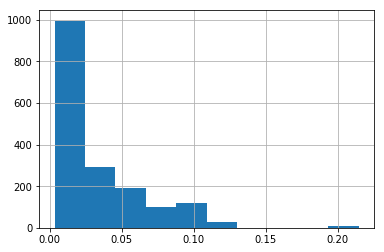

In [49]:
final_df,grouped_df,hist = Swiss_tourney(x_train,y_train,1000,30,6,100)

In [52]:
def low_high_imp_grouping(df,p):
    df['Group'] = np.where(grouped_df['feature_imp'] <= np.percentile(grouped_df['feature_imp'],p),'Low','High')
    return(df)

In [53]:
grouped_df = low_high_imp_grouping(grouped_df,90)

In [54]:
list_of_imp_features = list(grouped_df[grouped_df.Group == 'High'].feature)

In [55]:
x_train_imp = x_train.loc[:,list_of_imp_features]


In [56]:
x_train_imp.shape

(100, 174)

### VIF Based Removal

In [57]:
## VIF based removal
def Vif_Rem(df,r_square_threshold):
    
    """
    Function to  remove variables iteratively that are multicollinear with other variables in the dataset.
    
    # Arguments
        df: Input dataframe
        r_square_threshold: R-Square-Threshold to remove variables. 
                            0.9 r-square corresponds to a VIF of 10 , 0.8 r-square corresponds to a VIF of 5
        
    # Returns
        dataframe: Return a dataframe with non collinear variables.
    """

    lr = LinearRegression()
    for col in df.columns:
        lr.fit(df.drop([col],axis=1),df[col])
        if lr.score(df.drop([col],axis=1),df[col]) >= r_square_threshold:  # R-square - 0.9 corresponds to a VIF of 5
            df=df.drop([col],axis=1)
    return(df)  

In [58]:
x_train_imp = Vif_Rem(x_train_imp,0.9)

In [59]:
x_train_imp.shape

(100, 6)

In [60]:
# Using train columns to subset test columns
x_test_imp = x_test.loc[:,x_train_imp.columns]


In [61]:
x_test_imp.shape

(32, 6)

### Linear regression

In [62]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x_train_imp,y_train)
predict= lr.predict(x_test_imp)

In [64]:
df_lr = pd.DataFrame({'predict':predict,'actual':y_test})
df_lr['APE'] = abs(df_lr.predict-df_lr.actual)/df_lr.actual

In [65]:
df_lr.head()

predict    actual       APE
100  0.291296  0.292000  0.002409
101  0.294560  0.295455  0.003027
102  0.292267  0.297273  0.016838
103  0.293083  0.291905  0.004038
104  0.244411  0.248095  0.014851

In [66]:
print('Mape is :' , np.mean(df_lr.APE))

Mape is : 0.012641255755191714


### GBM with Hyperparameter tuning

In [67]:

from sklearn.ensemble import GradientBoostingRegressor 
def gbm(max_depth_l,min_samples_split_l,n_estimators_l,learning_rate_l,x,y):
    param_test = {'max_depth':max_depth_l, 'min_samples_split':min_samples_split_l,
                   'n_estimators': n_estimators_l, 'learning_rate': learning_rate_l}
    gsearch = GridSearchCV(estimator = GradientBoostingRegressor(max_features='sqrt', subsample=0.8, random_state=10), 
    param_grid = param_test, scoring='r2',n_jobs=4,iid=False, cv=5)
    gsearch.fit(x,y)
    #gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

    
    return(gsearch.best_params_)
    

In [68]:
gbm([3,5,7],[3,5],[20,50,100],[0.1,0.2],x_train_imp,y_train)

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_samples_split': 3,
 'n_estimators': 100}

In [71]:
gbm = GradientBoostingRegressor(learning_rate = 0.1 , min_samples_split =3,
                                n_estimators = 100, max_depth = 5)
gbm.fit(x_train_imp,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [72]:
predict = gbm.predict(x_test_imp)

In [73]:
df_gbm = pd.DataFrame({'predict':predict,'actual':y_test})

In [74]:
df_gbm.head()

predict    actual
100  0.292857  0.292000
101  0.292857  0.295455
102  0.292857  0.297273
103  0.292857  0.291905
104  0.246889  0.248095

In [75]:
df_gbm['APE'] = abs(df_gbm.predict-df_gbm.actual)/df_gbm.actual

In [76]:
print('Mape is :' , np.mean(df_gbm.APE))

Mape is : 0.019478622150255493
